# Currency Market Predictor - Deep Regressor

Predicting EURUSD market

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('EURUSD_TechnicalIndicators.csv')
dataset.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,1.3638,1.3630,0.001322,83.268482,0.0086
1,1.3630,1.3621,0.001137,80.155642,0.0100


#### Normalize

In [3]:
dataset = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
dataset.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.121300,0.119981,0.027770,0.336375,-0.076375
1,0.119872,0.118375,0.023829,0.305247,-0.049555


## Hyperparams

In [4]:
num_epochs = 10000

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2616
The current configuration gives us 872 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [5]:
datasetTrain = dataset[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(dataset.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dataset.index)-i
        break

datasetTest =  dataset[dataset.index >= test_first_idx]

In [6]:
datasetTrain.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.121300,0.119981,0.027770,0.336375,-0.076375
1,0.119872,0.118375,0.023829,0.305247,-0.049555


In [7]:
datasetTest.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
2514,-0.401285,-0.400104,-0.011668,0.343968,-0.168329
2515,-0.400214,-0.398140,-0.002441,0.385635,-0.105111


In [8]:
xTrain = datasetTrain[['Close','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [9]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[ 0.12130035  0.02777039  0.33637511 -0.07637498]
 [ 0.11987204  0.02382894  0.30524671 -0.04955505]
 [ 0.11826518  0.01903532  0.27022725 -0.13959337]] 
 [ 0.11998144  0.11837459  0.11587503]


In [10]:
xTest = datasetTest[['Close','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [11]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.4012849  -0.01166827  0.34396806 -0.168329  ]
 [-0.40021366 -0.00244109  0.38563473 -0.10511061]
 [-0.39824973  0.0057795   0.46202362 -0.13193053]] 
 [-0.40010426 -0.39814032 -0.37332333]


## Visualize starting price data

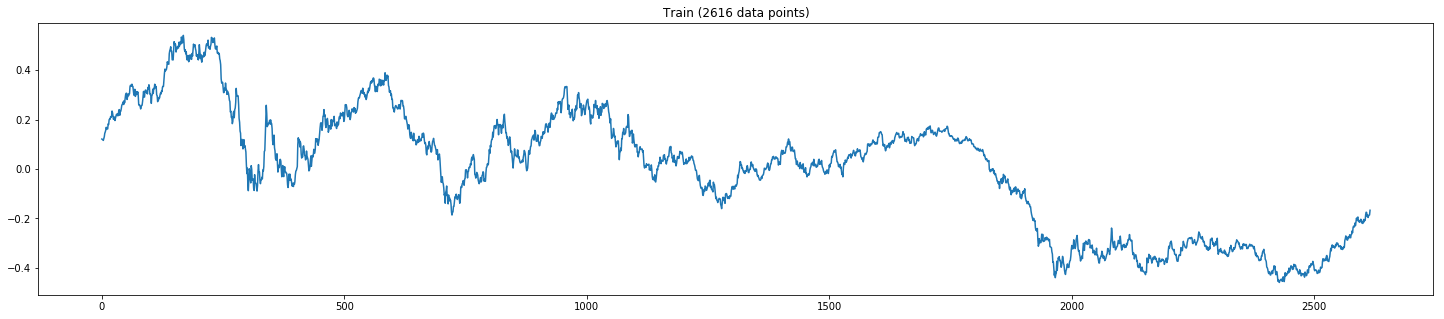

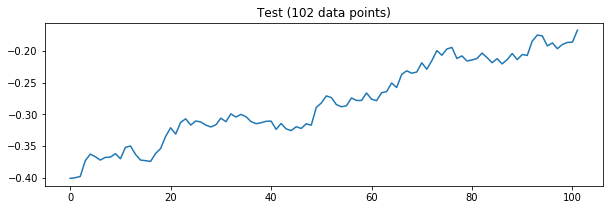

In [12]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Classifier model

In [13]:
LEARNING_RATE = 0.001
BATCH_SIZE = 1

x = tf.placeholder(tf.float32,[None,num_features],name='x')
y = tf.placeholder(tf.float32,[None],name='y')

In [14]:
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

#Layer1
WRelu1 = tf.Variable(tf.truncated_normal([num_features,num_features]),dtype=tf.float32,name='wrelu1')
bRelu1 = tf.Variable(tf.truncated_normal([num_features]),dtype=tf.float32,name='brelu1')
relu1 = tf.nn.elu(tf.matmul(x,WRelu1) + bRelu1,name='relu1')

#DROPOUT
relu1 = tf.nn.dropout(relu1,keep_prob=keep_prob,name='relu1drop')

#Layer2
WRelu2 = tf.Variable(tf.truncated_normal([num_features,num_features]),dtype=tf.float32,name='wrelu2')
bRelu2 = tf.Variable(tf.truncated_normal([num_features]),dtype=tf.float32,name='brelu2')
layer2 = tf.add(tf.add(tf.matmul(relu1,WRelu2),bRelu2),x,name='layer2')

relu2 = tf.nn.elu(layer2,name='relu2')

#Layer3
WRelu3 = tf.Variable(tf.truncated_normal([num_features,num_features]),dtype=tf.float32,name='wrelu3')
bRelu3 = tf.Variable(tf.truncated_normal([num_features]),dtype=tf.float32,name='brelu3')
relu3 = tf.nn.elu(tf.matmul(relu2,WRelu3) + bRelu3,name='relu3')


#DROPOUT
relu3 = tf.nn.dropout(relu3,keep_prob=keep_prob,name='relu3drop')

#Out layer
Wout = tf.Variable(tf.truncated_normal([num_features,1]),dtype=tf.float32,name='wout')
bout = tf.Variable(tf.truncated_normal([1]),dtype=tf.float32,name='bout')
logits = tf.add(tf.matmul(relu3,Wout),bout,name='logits')


#Predictions
pred = logits

#Cost & Optimizer
cost = tf.reduce_mean(tf.squared_difference(y, logits))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cost)

In [15]:
def train_one_classifier(num_epochs,label_n):
    display_freq = num_epochs//10

    loss_list = []
    loss_list_batch = []

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        for step in range(num_epochs):
            print('Step: %d' %step)

            for batch_idx in range(num_batches):
                
                batchx = xTrain[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE,:]
                batchy = yTrain[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE].ravel()

                feed = {x: batchx, y: batchy, keep_prob:0.5}
                
                _,_loss = sess.run([optimizer,cost], feed_dict=feed)
                loss_list_batch.append(np.average(_loss)) #Store av. batch loss

            #Add the av. loss of the batch to the loss list
            loss_list.append(np.average(loss_list_batch))
            loss_list_batch = []
                        
            if(step == 1):
                print('Initial loss: %.3f' % np.average(_loss))


        
        feed_dev = {x : xTest, y : yTest.ravel(), keep_prob:1}
        _y,_softmax,_pred = sess.run([y,logits,pred],feed_dict=feed_dev)
        
        print('Train finished - Final loss: %.3f' % (np.average(_loss)))
        
        
    return loss_list,_y,_pred

In [16]:
loss_list,_y,_pred = train_one_classifier(num_epochs,1)

Step: 0
Step: 1
Initial loss: 0.010
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108


Step: 829
Step: 830
Step: 831
Step: 832
Step: 833
Step: 834
Step: 835
Step: 836
Step: 837
Step: 838
Step: 839
Step: 840
Step: 841
Step: 842
Step: 843
Step: 844
Step: 845
Step: 846
Step: 847
Step: 848
Step: 849
Step: 850
Step: 851
Step: 852
Step: 853
Step: 854
Step: 855
Step: 856
Step: 857
Step: 858
Step: 859
Step: 860
Step: 861
Step: 862
Step: 863
Step: 864
Step: 865
Step: 866
Step: 867
Step: 868
Step: 869
Step: 870
Step: 871
Step: 872
Step: 873
Step: 874
Step: 875
Step: 876
Step: 877
Step: 878
Step: 879
Step: 880
Step: 881
Step: 882
Step: 883
Step: 884
Step: 885
Step: 886
Step: 887
Step: 888
Step: 889
Step: 890
Step: 891
Step: 892
Step: 893
Step: 894
Step: 895
Step: 896
Step: 897
Step: 898
Step: 899
Step: 900
Step: 901
Step: 902
Step: 903
Step: 904
Step: 905
Step: 906
Step: 907
Step: 908
Step: 909
Step: 910
Step: 911
Step: 912
Step: 913
Step: 914
Step: 915
Step: 916
Step: 917
Step: 918
Step: 919
Step: 920
Step: 921
Step: 922
Step: 923
Step: 924
Step: 925
Step: 926
Step: 927
Step: 928


Step: 1590
Step: 1591
Step: 1592
Step: 1593
Step: 1594
Step: 1595
Step: 1596
Step: 1597
Step: 1598
Step: 1599
Step: 1600
Step: 1601
Step: 1602
Step: 1603
Step: 1604
Step: 1605
Step: 1606
Step: 1607
Step: 1608
Step: 1609
Step: 1610
Step: 1611
Step: 1612
Step: 1613
Step: 1614
Step: 1615
Step: 1616
Step: 1617
Step: 1618
Step: 1619
Step: 1620
Step: 1621
Step: 1622
Step: 1623
Step: 1624
Step: 1625
Step: 1626
Step: 1627
Step: 1628
Step: 1629
Step: 1630
Step: 1631
Step: 1632
Step: 1633
Step: 1634
Step: 1635
Step: 1636
Step: 1637
Step: 1638
Step: 1639
Step: 1640
Step: 1641
Step: 1642
Step: 1643
Step: 1644
Step: 1645
Step: 1646
Step: 1647
Step: 1648
Step: 1649
Step: 1650
Step: 1651
Step: 1652
Step: 1653
Step: 1654
Step: 1655
Step: 1656
Step: 1657
Step: 1658
Step: 1659
Step: 1660
Step: 1661
Step: 1662
Step: 1663
Step: 1664
Step: 1665
Step: 1666
Step: 1667
Step: 1668
Step: 1669
Step: 1670
Step: 1671
Step: 1672
Step: 1673
Step: 1674
Step: 1675
Step: 1676
Step: 1677
Step: 1678
Step: 1679
Step: 1680

Step: 2335
Step: 2336
Step: 2337
Step: 2338
Step: 2339
Step: 2340
Step: 2341
Step: 2342
Step: 2343
Step: 2344
Step: 2345
Step: 2346
Step: 2347
Step: 2348
Step: 2349
Step: 2350
Step: 2351
Step: 2352
Step: 2353
Step: 2354
Step: 2355
Step: 2356
Step: 2357
Step: 2358
Step: 2359
Step: 2360
Step: 2361
Step: 2362
Step: 2363
Step: 2364
Step: 2365
Step: 2366
Step: 2367
Step: 2368
Step: 2369
Step: 2370
Step: 2371
Step: 2372
Step: 2373
Step: 2374
Step: 2375
Step: 2376
Step: 2377
Step: 2378
Step: 2379
Step: 2380
Step: 2381
Step: 2382
Step: 2383
Step: 2384
Step: 2385
Step: 2386
Step: 2387
Step: 2388
Step: 2389
Step: 2390
Step: 2391
Step: 2392
Step: 2393
Step: 2394
Step: 2395
Step: 2396
Step: 2397
Step: 2398
Step: 2399
Step: 2400
Step: 2401
Step: 2402
Step: 2403
Step: 2404
Step: 2405
Step: 2406
Step: 2407
Step: 2408
Step: 2409
Step: 2410
Step: 2411
Step: 2412
Step: 2413
Step: 2414
Step: 2415
Step: 2416
Step: 2417
Step: 2418
Step: 2419
Step: 2420
Step: 2421
Step: 2422
Step: 2423
Step: 2424
Step: 2425

Step: 3080
Step: 3081
Step: 3082
Step: 3083
Step: 3084
Step: 3085
Step: 3086
Step: 3087
Step: 3088
Step: 3089
Step: 3090
Step: 3091
Step: 3092
Step: 3093
Step: 3094
Step: 3095
Step: 3096
Step: 3097
Step: 3098
Step: 3099
Step: 3100
Step: 3101
Step: 3102
Step: 3103
Step: 3104
Step: 3105
Step: 3106
Step: 3107
Step: 3108
Step: 3109
Step: 3110
Step: 3111
Step: 3112
Step: 3113
Step: 3114
Step: 3115
Step: 3116
Step: 3117
Step: 3118
Step: 3119
Step: 3120
Step: 3121
Step: 3122
Step: 3123
Step: 3124
Step: 3125
Step: 3126
Step: 3127
Step: 3128
Step: 3129
Step: 3130
Step: 3131
Step: 3132
Step: 3133
Step: 3134
Step: 3135
Step: 3136
Step: 3137
Step: 3138
Step: 3139
Step: 3140
Step: 3141
Step: 3142
Step: 3143
Step: 3144
Step: 3145
Step: 3146
Step: 3147
Step: 3148
Step: 3149
Step: 3150
Step: 3151
Step: 3152
Step: 3153
Step: 3154
Step: 3155
Step: 3156
Step: 3157
Step: 3158
Step: 3159
Step: 3160
Step: 3161
Step: 3162
Step: 3163
Step: 3164
Step: 3165
Step: 3166
Step: 3167
Step: 3168
Step: 3169
Step: 3170

Step: 3825
Step: 3826
Step: 3827
Step: 3828
Step: 3829
Step: 3830
Step: 3831
Step: 3832
Step: 3833
Step: 3834
Step: 3835
Step: 3836
Step: 3837
Step: 3838
Step: 3839
Step: 3840
Step: 3841
Step: 3842
Step: 3843
Step: 3844
Step: 3845
Step: 3846
Step: 3847
Step: 3848
Step: 3849
Step: 3850
Step: 3851
Step: 3852
Step: 3853
Step: 3854
Step: 3855
Step: 3856
Step: 3857
Step: 3858
Step: 3859
Step: 3860
Step: 3861
Step: 3862
Step: 3863
Step: 3864
Step: 3865
Step: 3866
Step: 3867
Step: 3868
Step: 3869
Step: 3870
Step: 3871
Step: 3872
Step: 3873
Step: 3874
Step: 3875
Step: 3876
Step: 3877
Step: 3878
Step: 3879
Step: 3880
Step: 3881
Step: 3882
Step: 3883
Step: 3884
Step: 3885
Step: 3886
Step: 3887
Step: 3888
Step: 3889
Step: 3890
Step: 3891
Step: 3892
Step: 3893
Step: 3894
Step: 3895
Step: 3896
Step: 3897
Step: 3898
Step: 3899
Step: 3900
Step: 3901
Step: 3902
Step: 3903
Step: 3904
Step: 3905
Step: 3906
Step: 3907
Step: 3908
Step: 3909
Step: 3910
Step: 3911
Step: 3912
Step: 3913
Step: 3914
Step: 3915

Step: 4570
Step: 4571
Step: 4572
Step: 4573
Step: 4574
Step: 4575
Step: 4576
Step: 4577
Step: 4578
Step: 4579
Step: 4580
Step: 4581
Step: 4582
Step: 4583
Step: 4584
Step: 4585
Step: 4586
Step: 4587
Step: 4588
Step: 4589
Step: 4590
Step: 4591
Step: 4592
Step: 4593
Step: 4594
Step: 4595
Step: 4596
Step: 4597
Step: 4598
Step: 4599
Step: 4600
Step: 4601
Step: 4602
Step: 4603
Step: 4604
Step: 4605
Step: 4606
Step: 4607
Step: 4608
Step: 4609
Step: 4610
Step: 4611
Step: 4612
Step: 4613
Step: 4614
Step: 4615
Step: 4616
Step: 4617
Step: 4618
Step: 4619
Step: 4620
Step: 4621
Step: 4622
Step: 4623
Step: 4624
Step: 4625
Step: 4626
Step: 4627
Step: 4628
Step: 4629
Step: 4630
Step: 4631
Step: 4632
Step: 4633
Step: 4634
Step: 4635
Step: 4636
Step: 4637
Step: 4638
Step: 4639
Step: 4640
Step: 4641
Step: 4642
Step: 4643
Step: 4644
Step: 4645
Step: 4646
Step: 4647
Step: 4648
Step: 4649
Step: 4650
Step: 4651
Step: 4652
Step: 4653
Step: 4654
Step: 4655
Step: 4656
Step: 4657
Step: 4658
Step: 4659
Step: 4660

Step: 5315
Step: 5316
Step: 5317
Step: 5318
Step: 5319
Step: 5320
Step: 5321
Step: 5322
Step: 5323
Step: 5324
Step: 5325
Step: 5326
Step: 5327
Step: 5328
Step: 5329
Step: 5330
Step: 5331
Step: 5332
Step: 5333
Step: 5334
Step: 5335
Step: 5336
Step: 5337
Step: 5338
Step: 5339
Step: 5340
Step: 5341
Step: 5342
Step: 5343
Step: 5344
Step: 5345
Step: 5346
Step: 5347
Step: 5348
Step: 5349
Step: 5350
Step: 5351
Step: 5352
Step: 5353
Step: 5354
Step: 5355
Step: 5356
Step: 5357
Step: 5358
Step: 5359
Step: 5360
Step: 5361
Step: 5362
Step: 5363
Step: 5364
Step: 5365
Step: 5366
Step: 5367
Step: 5368
Step: 5369
Step: 5370
Step: 5371
Step: 5372
Step: 5373
Step: 5374
Step: 5375
Step: 5376
Step: 5377
Step: 5378
Step: 5379
Step: 5380
Step: 5381
Step: 5382
Step: 5383
Step: 5384
Step: 5385
Step: 5386
Step: 5387
Step: 5388
Step: 5389
Step: 5390
Step: 5391
Step: 5392
Step: 5393
Step: 5394
Step: 5395
Step: 5396
Step: 5397
Step: 5398
Step: 5399
Step: 5400
Step: 5401
Step: 5402
Step: 5403
Step: 5404
Step: 5405

Step: 6060
Step: 6061
Step: 6062
Step: 6063
Step: 6064
Step: 6065
Step: 6066
Step: 6067
Step: 6068
Step: 6069
Step: 6070
Step: 6071
Step: 6072
Step: 6073
Step: 6074
Step: 6075
Step: 6076
Step: 6077
Step: 6078
Step: 6079
Step: 6080
Step: 6081
Step: 6082
Step: 6083
Step: 6084
Step: 6085
Step: 6086
Step: 6087
Step: 6088
Step: 6089
Step: 6090
Step: 6091
Step: 6092
Step: 6093
Step: 6094
Step: 6095
Step: 6096
Step: 6097
Step: 6098
Step: 6099
Step: 6100
Step: 6101
Step: 6102
Step: 6103
Step: 6104
Step: 6105
Step: 6106
Step: 6107
Step: 6108
Step: 6109
Step: 6110
Step: 6111
Step: 6112
Step: 6113
Step: 6114
Step: 6115
Step: 6116
Step: 6117
Step: 6118
Step: 6119
Step: 6120
Step: 6121
Step: 6122
Step: 6123
Step: 6124
Step: 6125
Step: 6126
Step: 6127
Step: 6128
Step: 6129
Step: 6130
Step: 6131
Step: 6132
Step: 6133
Step: 6134
Step: 6135
Step: 6136
Step: 6137
Step: 6138
Step: 6139
Step: 6140
Step: 6141
Step: 6142
Step: 6143
Step: 6144
Step: 6145
Step: 6146
Step: 6147
Step: 6148
Step: 6149
Step: 6150

Step: 6805
Step: 6806
Step: 6807
Step: 6808
Step: 6809
Step: 6810
Step: 6811
Step: 6812
Step: 6813
Step: 6814
Step: 6815
Step: 6816
Step: 6817
Step: 6818
Step: 6819
Step: 6820
Step: 6821
Step: 6822
Step: 6823
Step: 6824
Step: 6825
Step: 6826
Step: 6827
Step: 6828
Step: 6829
Step: 6830
Step: 6831
Step: 6832
Step: 6833
Step: 6834
Step: 6835
Step: 6836
Step: 6837
Step: 6838
Step: 6839
Step: 6840
Step: 6841
Step: 6842
Step: 6843
Step: 6844
Step: 6845
Step: 6846
Step: 6847
Step: 6848
Step: 6849
Step: 6850
Step: 6851
Step: 6852
Step: 6853
Step: 6854
Step: 6855
Step: 6856
Step: 6857
Step: 6858
Step: 6859
Step: 6860
Step: 6861
Step: 6862
Step: 6863
Step: 6864
Step: 6865
Step: 6866
Step: 6867
Step: 6868
Step: 6869
Step: 6870
Step: 6871
Step: 6872
Step: 6873
Step: 6874
Step: 6875
Step: 6876
Step: 6877
Step: 6878
Step: 6879
Step: 6880
Step: 6881
Step: 6882
Step: 6883
Step: 6884
Step: 6885
Step: 6886
Step: 6887
Step: 6888
Step: 6889
Step: 6890
Step: 6891
Step: 6892
Step: 6893
Step: 6894
Step: 6895

Step: 7550
Step: 7551
Step: 7552
Step: 7553
Step: 7554
Step: 7555
Step: 7556
Step: 7557
Step: 7558
Step: 7559
Step: 7560
Step: 7561
Step: 7562
Step: 7563
Step: 7564
Step: 7565
Step: 7566
Step: 7567
Step: 7568
Step: 7569
Step: 7570
Step: 7571
Step: 7572
Step: 7573
Step: 7574
Step: 7575
Step: 7576
Step: 7577
Step: 7578
Step: 7579
Step: 7580
Step: 7581
Step: 7582
Step: 7583
Step: 7584
Step: 7585
Step: 7586
Step: 7587
Step: 7588
Step: 7589
Step: 7590
Step: 7591
Step: 7592
Step: 7593
Step: 7594
Step: 7595
Step: 7596
Step: 7597
Step: 7598
Step: 7599
Step: 7600
Step: 7601
Step: 7602
Step: 7603
Step: 7604
Step: 7605
Step: 7606
Step: 7607
Step: 7608
Step: 7609
Step: 7610
Step: 7611
Step: 7612
Step: 7613
Step: 7614
Step: 7615
Step: 7616
Step: 7617
Step: 7618
Step: 7619
Step: 7620
Step: 7621
Step: 7622
Step: 7623
Step: 7624
Step: 7625
Step: 7626
Step: 7627
Step: 7628
Step: 7629
Step: 7630
Step: 7631
Step: 7632
Step: 7633
Step: 7634
Step: 7635
Step: 7636
Step: 7637
Step: 7638
Step: 7639
Step: 7640

Step: 8295
Step: 8296
Step: 8297
Step: 8298
Step: 8299
Step: 8300
Step: 8301
Step: 8302
Step: 8303
Step: 8304
Step: 8305
Step: 8306
Step: 8307
Step: 8308
Step: 8309
Step: 8310
Step: 8311
Step: 8312
Step: 8313
Step: 8314
Step: 8315
Step: 8316
Step: 8317
Step: 8318
Step: 8319
Step: 8320
Step: 8321
Step: 8322
Step: 8323
Step: 8324
Step: 8325
Step: 8326
Step: 8327
Step: 8328
Step: 8329
Step: 8330
Step: 8331
Step: 8332
Step: 8333
Step: 8334
Step: 8335
Step: 8336
Step: 8337
Step: 8338
Step: 8339
Step: 8340
Step: 8341
Step: 8342
Step: 8343
Step: 8344
Step: 8345
Step: 8346
Step: 8347
Step: 8348
Step: 8349
Step: 8350
Step: 8351
Step: 8352
Step: 8353
Step: 8354
Step: 8355
Step: 8356
Step: 8357
Step: 8358
Step: 8359
Step: 8360
Step: 8361
Step: 8362
Step: 8363
Step: 8364
Step: 8365
Step: 8366
Step: 8367
Step: 8368
Step: 8369
Step: 8370
Step: 8371
Step: 8372
Step: 8373
Step: 8374
Step: 8375
Step: 8376
Step: 8377
Step: 8378
Step: 8379
Step: 8380
Step: 8381
Step: 8382
Step: 8383
Step: 8384
Step: 8385

Step: 9040
Step: 9041
Step: 9042
Step: 9043
Step: 9044
Step: 9045
Step: 9046
Step: 9047
Step: 9048
Step: 9049
Step: 9050
Step: 9051
Step: 9052
Step: 9053
Step: 9054
Step: 9055
Step: 9056
Step: 9057
Step: 9058
Step: 9059
Step: 9060
Step: 9061
Step: 9062
Step: 9063
Step: 9064
Step: 9065
Step: 9066
Step: 9067
Step: 9068
Step: 9069
Step: 9070
Step: 9071
Step: 9072
Step: 9073
Step: 9074
Step: 9075
Step: 9076
Step: 9077
Step: 9078
Step: 9079
Step: 9080
Step: 9081
Step: 9082
Step: 9083
Step: 9084
Step: 9085
Step: 9086
Step: 9087
Step: 9088
Step: 9089
Step: 9090
Step: 9091
Step: 9092
Step: 9093
Step: 9094
Step: 9095
Step: 9096
Step: 9097
Step: 9098
Step: 9099
Step: 9100
Step: 9101
Step: 9102
Step: 9103
Step: 9104
Step: 9105
Step: 9106
Step: 9107
Step: 9108
Step: 9109
Step: 9110
Step: 9111
Step: 9112
Step: 9113
Step: 9114
Step: 9115
Step: 9116
Step: 9117
Step: 9118
Step: 9119
Step: 9120
Step: 9121
Step: 9122
Step: 9123
Step: 9124
Step: 9125
Step: 9126
Step: 9127
Step: 9128
Step: 9129
Step: 9130

Step: 9785
Step: 9786
Step: 9787
Step: 9788
Step: 9789
Step: 9790
Step: 9791
Step: 9792
Step: 9793
Step: 9794
Step: 9795
Step: 9796
Step: 9797
Step: 9798
Step: 9799
Step: 9800
Step: 9801
Step: 9802
Step: 9803
Step: 9804
Step: 9805
Step: 9806
Step: 9807
Step: 9808
Step: 9809
Step: 9810
Step: 9811
Step: 9812
Step: 9813
Step: 9814
Step: 9815
Step: 9816
Step: 9817
Step: 9818
Step: 9819
Step: 9820
Step: 9821
Step: 9822
Step: 9823
Step: 9824
Step: 9825
Step: 9826
Step: 9827
Step: 9828
Step: 9829
Step: 9830
Step: 9831
Step: 9832
Step: 9833
Step: 9834
Step: 9835
Step: 9836
Step: 9837
Step: 9838
Step: 9839
Step: 9840
Step: 9841
Step: 9842
Step: 9843
Step: 9844
Step: 9845
Step: 9846
Step: 9847
Step: 9848
Step: 9849
Step: 9850
Step: 9851
Step: 9852
Step: 9853
Step: 9854
Step: 9855
Step: 9856
Step: 9857
Step: 9858
Step: 9859
Step: 9860
Step: 9861
Step: 9862
Step: 9863
Step: 9864
Step: 9865
Step: 9866
Step: 9867
Step: 9868
Step: 9869
Step: 9870
Step: 9871
Step: 9872
Step: 9873
Step: 9874
Step: 9875

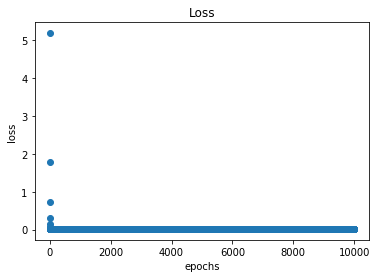

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

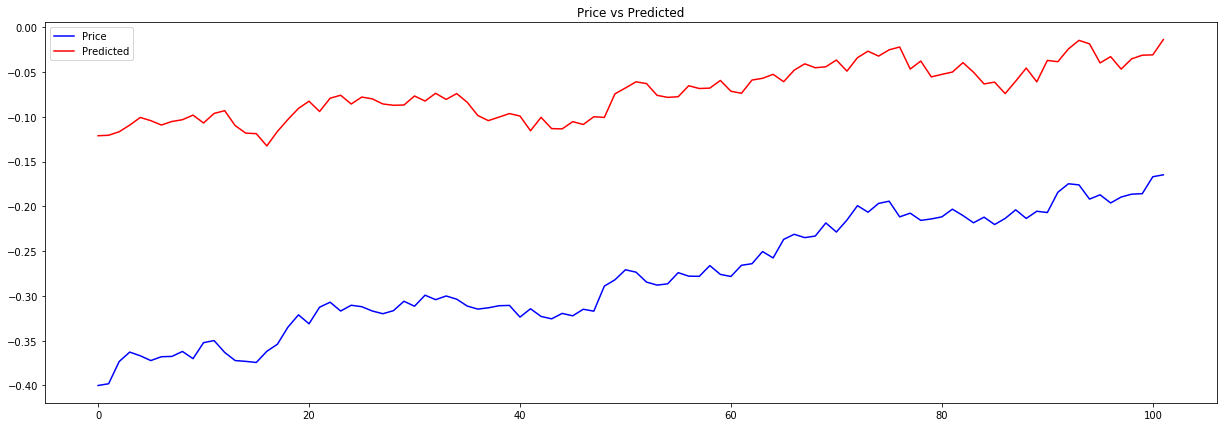

In [18]:
plt.figure(figsize=(21,7))
plt.plot(_y,label='Price',color='blue')
plt.plot(_pred.ravel(),label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()